In [45]:
from IPython.display import HTML
from sklearn.neighbors import NearestNeighbors

In [46]:
import pandas as pd
import networkx as nx
import community
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
from collections import defaultdict
from sklearn.neighbors import BallTree, NearestNeighbors
import gc
%matplotlib inline

columns = ["pubId", "is_hourly", "seqId", "on_homepage", "canonicalUrl",
                   "firstScrape", "lang_iso", "lang_reliability", "title", "text"]

def read_article_df(file):
    articles_dt = file.read().split('\n')[:-1]
    pubId, canonicalUrl,firstScrape,title,text,lang_reliability = [],[],[],[],[],[]
    lang_iso = []
    for article in articles_dt:    
        row = article.split('\t')
        pubId.append(row[0])
        canonicalUrl.append(row[4])
        firstScrape.append(row[5])
        lang_iso.append(row[6])
        lang_reliability.append(row[7])
        title.append(row[8])
        text.append(row[9])

    articles_df = pd.DataFrame()
    articles_df['pubId'] = pubId
    articles_df['canonicalUrl'] = canonicalUrl
    articles_df['firstScrape'] = firstScrape
    articles_df['title'] = title
    articles_df['text'] = text
    articles_df['lang_reliability'] = lang_reliability
    articles_df['lang_iso'] = lang_iso
    return articles_df

In [47]:
import numpy as np
emb = np.load('../data/embedding/BagOfWord_output.npy', allow_pickle=True)

In [48]:
emb = np.asmatrix(emb)[0,0]

In [49]:
article_df = read_article_df(open('../data/raw/2018_07_19_04_59_08/articles.txt', encoding='utf-8'))
article_df = article_df[article_df.lang_reliability == '1'].reset_index(drop=True)

In [ ]:
article_df['title'] = article_df.title.apply(lambda s: s.strip())
article_df['text'] = article_df.text.apply(lambda s: s.strip())
article_df['title_len'] = article_df.title.apply(len)
article_df['text_len'] = article_df.text.apply(len)

In [124]:
article_df.query('text_len == 0 and title_len == 0').shape

(3059, 9)

In [51]:
clean_df = article_df[article_df.title_len > 0]
clean_df = clean_df[clean_df.text_len > 100]
clean_df = clean_df[clean_df.lang_iso == 'en']
clean_df.shape

(176664, 9)

In [52]:
def load_label(file='lower_bound'):
    label1 = pd.read_csv(f'../data/raw/labels/cave_rescue/{file}.txt', header=None)
    label1.columns = ['canonicalUrl']
    label1['label'] = 'cave_rescue'

    label2 = pd.read_csv(f'../data/raw/labels/duckboat/{file}.txt', header=None)
    label2.columns = ['canonicalUrl']
    label2['label'] = 'duckboat'

    label3 = pd.read_csv(f'../data/raw/labels/helsinki_summit/{file}.txt', header=None)
    label3.columns = ['canonicalUrl']
    label3['label'] = 'helsinki'

    label_df = pd.concat([label1, label2, label3])
    return label_df

label_df = load_label('lower_bound')

In [53]:
clean_df = clean_df.merge(label_df, on='canonicalUrl', how='left')

In [54]:
clean_df.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
0,290,zerohedge.com/news/2018-07-19/i-told-you-so-tr...,7/19/2018 10:41:26 AM -04:00,"""I Told You So"": Trump Hits Out At EU After $5...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,79,2134,NaN
1,290,zerohedge.com/news/2018-07-19/trump-invites-pu...,7/19/2018 5:03:01 PM -04:00,Trump Invites Putin To Ahead Of Midterms | Ze...,"by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,54,4555,NaN
2,290,zerohedge.com/news/2018-07-19/gallup-shows-how...,7/19/2018 8:26:52 AM -04:00,Gallup Shows How Much Americans Really Care Ab...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,76,3133,NaN
3,290,zerohedge.com/news/2018-07-19/california-supre...,7/19/2018 8:26:52 AM -04:00,California Supreme Court Blocks Proposal To Sp...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,85,3567,NaN
4,290,zerohedge.com/news/2018-07-19/why-are-thousand...,7/19/2018 4:28:52 PM -04:00,"Why Are ""Thousands"" of Teslas Sitting In a Fie...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,62,3584,NaN


In [55]:
article_with_label = clean_df[~clean_df.label.isna()]
article_without_label = clean_df[clean_df.label.isna()]
article_with_label.shape, article_without_label.shape

((140, 10), (176524, 10))

Sample and include all the labeled article

In [56]:
sample_df = pd.concat([article_with_label, article_without_label.sample(10000)])
sample_emb = emb[sample_df.index]
np.mean(euclidean_distances(sample_emb))

41.332902463509654

In [57]:
nn = NearestNeighbors(radius=10)
nn.fit(sample_emb)
admat = nn.radius_neighbors_graph(); admat

<10140x10140 sparse matrix of type '<class 'numpy.float64'>'
	with 4476298 stored elements in Compressed Sparse Row format>

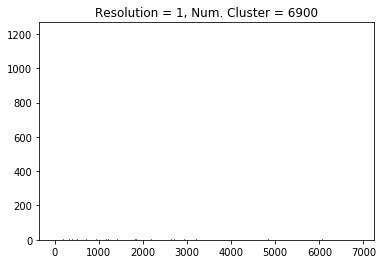

In [58]:
G = nx.from_scipy_sparse_matrix(admat)

partitions = []
resolutions = [1] #, .99, .999, .9995, .9999]
for resolution in resolutions:
    partition = community.best_partition(G, resolution=resolution)
    partitions.append(partition)
    num_cluster = max([v for k,v in partition.items()]) + 1
    clusters = defaultdict(list)
    for k, v in partition.items():
        clusters[v].append(k)

    cluster_sizes = []
    for i, cluster in clusters.items():
        cluster_sizes.append(len(cluster))
    plt.bar(list(range(len(cluster_sizes))), cluster_sizes)
    plt.title(f'Resolution = {resolution}, Num. Cluster = {num_cluster}')
    plt.show()

In [59]:
np.argmax(cluster_sizes), np.max(cluster_sizes), np.median(cluster_sizes)

(2, 1207, 1.0)

In [60]:
def plot_cluster_sizes(cluster):
    cluster_sizes = []
    for i, c in cluster.items():
        cluster_sizes.append(len(c))
    plt.title(f'Num cluster = {len(cluster.keys())}')
    plt.hist(cluster_sizes)
    plt.show()
    
def prune_cluster(cluster: dict, threshold) -> dict:
    pc = {}
    for key, value in clusters.items():
        if len(value) > threshold:
            pc[key] = value
    return pc

In [61]:
pc = prune_cluster(cluster, 5)

In [62]:
article_cluster = list(map(lambda d: sample_df.iloc[d[1]], pc.items()))
len(article_cluster)

17

In [63]:
len(article_cluster[0].title.tolist())

1207

In [64]:
pc.keys()

dict_keys([2, 5, 25, 58, 103, 209, 280, 327, 617, 955, 1034, 1141, 1202, 1285, 1693, 2158, 3388])

In [65]:
n = len(pc.keys())
sample_cluster = np.random.randint(n)
print('-'*50, 'title', '-'*50)
print('\n'.join(article_cluster[sample_cluster].title.tolist()[:10]))
print('-'*50, 'text', '-'*50)
print('\n'.join(list(map(lambda x: x[:100], article_cluster[sample_cluster].text.tolist()[:10]))))

-------------------------------------------------- title --------------------------------------------------
From faith worker to cabinet minister, Tassi is ready to be voice for seniors
Woman faces retrial on charges of suffocating husband - KAIT Jonesboro, AR - Region 8 News, weather, sports
Brazilian police arrest 'Dr. Bumbum' after patient dies
Washington Redskins' Vernon Davis pulled off an epic proposal in Ocean City
LORRAINE HEROD
Big Blue dragon boaters to paddle for cancer support, health | Local | lacrossetribune.com
What does the future look like for soccer in America?
Jail Reform: NYC Inmates Get Free Calls After Charged For Phone Use | Black America Web
Here’s What Trump And NATO Should Do About Russia’s Aggressions
-------------------------------------------------- text --------------------------------------------------
From faith worker to cabinet minister, Tassi is ready to be voice for seniors ### Poll ### Do you su
Woman faces retrial on charges of suffocating husband 

## Top clusters

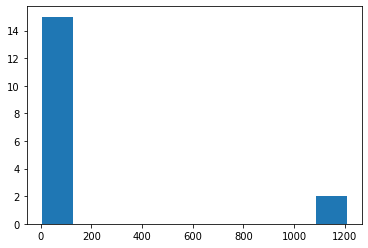

In [66]:
cluster_sizes = np.array(list(map(len, article_cluster)))
plt.hist(cluster_sizes);

In [67]:
index_by_size = list(reversed(np.argsort(cluster_sizes)))
cluster_sizes[index_by_size]

array([1207, 1153,   16,   12,   11,    9,    8,    8,    8,    8,    8,
          8,    7,    7,    6,    6,    6])

In [68]:
top_cluster = article_cluster[index_by_size[0]]
top_cluster.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
10801,33,washingtonpost.com/news/posteverything/wp/2018...,7/19/2018 6:27:03 AM -04:00,"Ukraine’s not a country, Putin told Bush. What...",PostEverything Perspective ### Perspective Int...,1,en,79,8487,helsinki
17607,34,bbc.co.uk/news/world-asia-44868907,7/19/2018 5:27:31 AM -04:00,Thai cave rescue boys relive 'moment of miracle,Thai cave rescue boys relive 'moment of miracl...,1,en,47,4668,cave_rescue
31434,16,news.google.com/stories/caaqaagkimjdqkltuxpvsm...,7/19/2018 5:36:57 PM -04:00,meets Vladimir Putin - Overview,Donald Trump meets Vladimir Putin ### Top cove...,1,en,31,13277,helsinki
41640,36,wsj.com/articles/eight-die-after-boat-capsizes...,7/19/2018 11:51:12 PM -04:00,Eight Die After Boat Capsizes in Storm Near Br...,### Eight Die After Boat Capsizes in Storm Nea...,1,en,63,572,duckboat
46718,414,fox2now.com/2018/07/19/mass-casualty-incident-...,7/19/2018 10:08:13 PM -04:00,‘Mass casualty incident’ reported at Table Roc...,‘Mass casualty incident’ reported at Table Roc...,1,en,66,910,duckboat


In [69]:
print('\n'.join(top_cluster.title.tolist()[:10]))

Ukraine’s not a country, Putin told Bush. What’d he tell Trump about Montenegro
Thai cave rescue boys relive 'moment of miracle
meets Vladimir Putin - Overview
Eight Die After Boat Capsizes in Storm Near Branson, Mo.  - WSJ
‘Mass casualty incident’ reported at Table Rock Lake | FOX2now.com
wave and smile in first public appearance after rescue
The 12 Russians indicted in the Mueller  will probably never face trial in the US
Trump and Putin morph into the same person on Time magazine cover
Watch as Trump’s Intel Director Dan Coats is stunned by news from the White House | TheBlaze
Russia slams proposal to question Trump summit translator | Daily Mail Online


In [70]:
for i, a in enumerate(article_cluster):
    a['assignment'] = i

C:\Users\harinsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
articles = pd.concat(article_cluster)
assignments = articles[['label', 'assignment', 'canonicalUrl']].groupby(['label', 'assignment']).count()
assignments.head()

canonicalUrl
label       assignment              
cave_rescue 0                      2
            1                      5
            3                      1
duckboat    0                      2
            1                      3

## Compare with K-Means

In [72]:
from sklearn.cluster import KMeans

In [73]:
cluster_sizes

array([1207, 1153,    8,    7,    6,    6,    8,    8,    7,   12,   16,
          6,   11,    8,    8,    8,    9])

In [74]:
articles_emb = emb[articles.index]

In [75]:
k = KMeans(n_clusters=len(cluster_sizes), n_jobs=-1)
k_predictions = k.fit_predict(articles_emb); k_predictions

array([ 1,  1,  1, ..., 12, 12, 12])

In [76]:
articles['k_assignment'] = k_predictions

In [77]:
com_scores = []
k_scores = []

print('      \t', 'community\t', 'k_mean')
for label in articles.label.unique():
    if not isinstance(label, str): continue
    a_cluster = articles[articles.label == label][['assignment', 'k_assignment']]
    max_cm_cluster = a_cluster.groupby('assignment').count().sort_values('k_assignment', ascending=False).index[0]
    max_km_cluster = a_cluster.groupby('k_assignment').count().sort_values('assignment', ascending=False).index[0]
    community_score = a_cluster[a_cluster.assignment == max_cm_cluster].shape[0] / a_cluster.shape[0]
    k_mean_score = a_cluster[a_cluster.k_assignment == max_km_cluster].shape[0] / a_cluster.shape[0]
    print(f'{label}\t{community_score:.3f}\t{k_mean_score:.3f}')
    com_scores.append(community_score)
    k_scores.append(k_mean_score)
print('-'*50)
print(f'mean\t\t{np.mean(com_scores):.3f}\t{np.mean(k_scores):.3f}')

      	 community	 k_mean
helsinki	0.458	0.750
cave_rescue	0.625	0.875
duckboat	0.600	1.000
--------------------------------------------------
mean		0.561	0.875


In [79]:
from sklearn.cluster import DBSCAN
import numpy as np

In [118]:
clustering = DBSCAN(eps=10, min_samples=5).fit(sample_emb)
set(clustering.labels_)

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32}

In [119]:
y_dbscan = pd.DataFrame({ 'y_dbscan': clustering.labels_ }, index=sample_df.index)
y_dbscan = y_dbscan.loc[articles.index]
articles = articles.drop(['y_dbscan'], axis=1)
articles = articles.join(y_dbscan)

In [121]:
com_scores = []
k_scores = []
db_scores = []

print('      \t', 'community\t', 'k_mean', '\t', 'dbscore')
for label in articles.label.unique():
    if not isinstance(label, str): continue
    a_cluster = articles[articles.label == label][['assignment', 'k_assignment', 'y_dbscan']]
    max_cm_cluster = a_cluster.groupby('assignment').count().sort_values('k_assignment', ascending=False).index[0]
    max_km_cluster = a_cluster.groupby('k_assignment').count().sort_values('assignment', ascending=False).index[0]
    max_db_cluster = a_cluster.groupby('y_dbscan').count().sort_values('assignment', ascending=False).index[0]
    
    community_score = a_cluster[a_cluster.assignment == max_cm_cluster].shape[0] / a_cluster.shape[0]
    k_mean_score = a_cluster[a_cluster.k_assignment == max_km_cluster].shape[0] / a_cluster.shape[0]
    db_score = a_cluster[a_cluster.assignment == max_db_cluster].shape[0] / a_cluster.shape[0]

    print(f'{label}\t{community_score:.3f}\t{k_mean_score:.3f}\t{db_score:.3f}')
    com_scores.append(community_score)
    k_scores.append(k_mean_score)
    db_scores.append(db_score)
print('-'*50)
print(f'mean\t\t{np.mean(com_scores):.3f}\t{np.mean(k_scores):.3f}\t{np.mean(db_scores):.3f}')

      	 community	 k_mean 	 dbscore
helsinki	0.458	0.750	0.458
cave_rescue	0.625	0.875	0.250
duckboat	0.600	1.000	0.400
--------------------------------------------------
mean		0.561	0.875	0.369


In [144]:
def max_cluster_acc(y_true, y_pred, name=None):
    labels = set(y_true)
    result = []
    for label in labels:
        if not isinstance(label, str): continue # remove NaN
        label_index = y_true == label
        
        cluster_size = {}
        cluster_labels = set(y_pred)
        max_cluster_label = -1
        max_cluster_size = -1
        for cluster_label in cluster_labels:
            count = np.sum(y_pred == cluster_label)
            if count > max_cluster_size:
                max_cluster_label = cluster_label
                max_cluster_size = count
                    
        num_correct = np.sum(y_pred[label_index] == max_cluster_label)
        
        num_true = np.sum(y_true == label)
        num_predict = np.sum(y_pred == max_cluster_label)
        
        precision = num_correct / max_cluster_size
        recall = num_correct / num_true
        scores = {
            'label': label,
            'precision': precision,
            'recall': recall,
        }
        if name: scores['name'] = name
        result.append(scores)
    return result
        
results = max_cluster_acc(articles.label, articles.y_dbscan, 'dbscan') +\
    max_cluster_acc(articles.label, articles.k_assignment, 'kmean') +\
    max_cluster_acc(articles.label, articles.assignment, 'cd')

In [157]:
agg_result = pd.DataFrame(results).groupby('name').mean()
agg_result['fscore'] = 2 * agg_result.precision * agg_result.recall / (agg_result.precision + agg_result.recall)
agg_result

,precision,recall,fscore
name,,,
cd,0.004143,0.369444,0.008193
dbscan,0.004904,0.944444,0.009757
kmean,0.004764,0.875000,0.009477


In [154]:
pd.DataFrame(results).pivot_table(['precision', 'recall'], ['name', 'label'])

precision    recall
name   label                           
cd     cave_rescue   0.001657  0.250000
       duckboat      0.001657  0.400000
       helsinki      0.009114  0.458333
dbscan cave_rescue   0.002942  0.875000
       duckboat      0.002102  1.000000
       helsinki      0.009668  0.958333
kmean  cave_rescue   0.003335  0.875000
       duckboat      0.002382  1.000000
       helsinki      0.008576  0.750000